# Plotting RBush

We want to see the structure of a RBush -- we want to plot the 2D spatial distribution of the items in a RBush tree.

We'll do that using [datashader][ds] and its companions, [xarray][xr], [bokeh][bk], [holoviews][hv], [pandas][pd], [numpy][np].

This exercise is based on:
* https://anaconda.org/jbednar/plotting_pitfalls/notebook
* https://anaconda.org/jbednar/pipeline/notebook

After a first approach, investigate/exercise the following:
* does bokeh-webgl engine support Rectangle glyph?


[ds]: http://datashader.readthedocs.io/
[xr]: http://xarray.pydata.org/
[bk]: https://bokeh.pydata.org
[hv]: http://holoviews.org/
[pd]: https://pandas.pydata.org/
[np]: http://www.numpy.org/

In [3]:
import datashader as ds
import xarray as xr
import bokeh as bk
import pandas as pd
import numpy as np
from numba import njit
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot, viridis

import rbush
from rbush.data import generate_data_array

In [4]:
print(ds.__version__)
print(xr.__version__)
print(bk.__version__)
print(pd.__version__)
print(np.__version__)

0.6.2
0.10.0
0.12.13
0.20.3
1.13.1


[RBush](https://github.com/parietal-io/py-rbush)
```
rbush.__version__ : '0.0.2+9.g355496a'
```

In [5]:
import rbush

In [21]:
from rbush.data import generate_data_array

def gaussian_grid(N, INCREMENT, SIZE):
    arrays = []

    # bottom-left
    arr = generate_data_array(N, SIZE)
    arr += SIZE
    arrays.append(arr)

    # top-right
    arr = generate_data_array(N, SIZE)
    arr += INCREMENT - SIZE
    arrays.append(arr)

    # bottom-right
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT - SIZE
    arr[:,1] += SIZE
    arr[:,2] += INCREMENT - SIZE
    arr[:,3] += SIZE
    arrays.append(arr)

    # top-left
    arr = generate_data_array(N, SIZE)
    arr[:,0] += SIZE
    arr[:,1] += INCREMENT - SIZE
    arr[:,2] += SIZE
    arr[:,3] += INCREMENT - SIZE
    arrays.append(arr)

    # top-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT // 2
    arr[:,1] += INCREMENT - SIZE
    arr[:,2] += INCREMENT // 2
    arr[:,3] += INCREMENT - SIZE
    arrays.append(arr)

    # bottom-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT // 2
    arr[:,1] += SIZE
    arr[:,2] += INCREMENT // 2
    arr[:,3] += SIZE
    arrays.append(arr)

    # left-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += SIZE
    arr[:,1] += INCREMENT // 2
    arr[:,2] += SIZE
    arr[:,3] += INCREMENT // 2
    arrays.append(arr)

    data = np.concatenate(arrays, axis=0)
    return data

N = int(1e5)
EXTENT = 1000
SIZE = 100
data = gaussian_grid(N, EXTENT, SIZE)
print('Length: {:,}'.format(len(data)))
data

Length: 700,000


array([[ -57.32936824,   59.71100538,   76.99421768,  -25.9608383 ],
       [ 111.27001049,    1.29334569,  189.25210043,   -7.56365855],
       [ -34.15114964,   46.56193872,   43.8024794 ,  151.70907518],
       ..., 
       [ -15.54463132,  504.37251578,   66.58986254,  391.09979608],
       [  43.12228349,  563.24397928,  103.94908788,  533.95511694],
       [  40.19960525,  428.86327436,    2.23168257,  404.14472879]])

In [22]:
t = rbush.RBush()
t.load(data)

In [26]:
items = t.all()
bboxes = np.asarray([[i.xmin, i.ymin, i.xmax, i.ymax] for i in items])
bboxes

array([[-147.14916431, -207.62492955,  -35.14111285, -291.61388542],
       [-146.31705687, -194.94946329, -265.50870153, -308.52751862],
       [-146.31459221, -169.90354371,  -20.54229462, -229.13876261],
       ..., 
       [-188.98411037, -136.13538519,  -96.79428066, -154.5684603 ],
       [-146.03120283, -148.24625579,  -94.29327796, -100.73579101],
       [  40.19960525,  428.86327436,    2.23168257,  404.14472879]])

In [27]:
# Apart from (raw) permutations, 'data' and 'bboxes' should contain the same information
assert data.shape==bboxes.shape

In [28]:
print(data.min(axis=0))
print(data.max(axis=0))
print(data.mean(axis=0))

[-400.47448268 -364.91871694 -573.13910198 -600.52636053]
[ 1332.59744159  1338.62077303  1591.93835072  1502.1690775 ]
[ 442.96092487  500.06644455  442.93735131  500.09775153]


In [29]:
print(bboxes.min(axis=0))
print(bboxes.max(axis=0))
print(bboxes.mean(axis=0))

[-228.9891272  -208.51966303 -327.23009181 -308.52751862]
[ 595.51667915  499.64645426  701.56959848  579.59283638]
[-169.16445695 -157.78360328 -142.95061347 -170.56375541]


**We see now that RBush has a (big) bug!** To not deviate from our exercise, let's use the `data` array, it's the same structure (as `bboxes`)

Datashader works in a canvas represented by an `xarray` where each element is a bin.
The bin represents a pixel in a (data) coordinates system.
Each bin contains information aggregated from the dataset(s) at that (pixel) position.

Let's say we want to count the number of items (bounding-boxes in our dataset) that cover each position in the dataset parameters space (xmin,ymin,xmax,ymax) -- a heatmap of the items distribution.
Each bin in the datashader (xarray) canvas will contain the number counts.

As a first approach, let's do the representation of items' centroids.
Then we evolve to plotting the boxes' coverage area.

In [30]:
df = pd.DataFrame(data, columns=['xmin','ymin','xmax','ymax'])
df['x'] = df[['xmin','xmax']].mean(axis=1)
df['y'] = df[['ymin','ymax']].mean(axis=1)

In [31]:
# We will represent centroids
glyph = ds.glyphs.Point('x', 'y')
glyph

In [32]:
# Say we want to see in a resolution of "1 data-unit" of the (variable) data axes range
# TODO: Numba-isze this and take sizes / resolution.
xres = 1
yres = 1

BORDER = 100
xlims = [int(df.xmin.min()) - BORDER, int(df.xmax.max()+1) + BORDER]
ylims = [int(df.ymin.min()) - BORDER, int(df.ymax.max()+1) + BORDER]

xsize = (xlims[1] - xlims[0])//xres
ysize = (ylims[1] - ylims[0])//yres


def def_pos2pix(pmin,res):
    pos_zero = int(pmin/res)
    def f(pos):
        return int(pos/res) - pos_zero
    return f


def def_pix2pos(pmin,res):
    def f(pix):
        return pix*res + pmin
    return f

pos2pix_x = def_pos2pix(xlims[0], xres)
pos2pix_y = def_pos2pix(ylims[0], yres)

pix2pos_x = def_pix2pos(xlims[0], xres)
pix2pos_y = def_pix2pos(ylims[0], yres)

In [33]:
canvas = ds.Canvas(plot_width=800, plot_height=400, x_range=xlims, y_range=ylims)

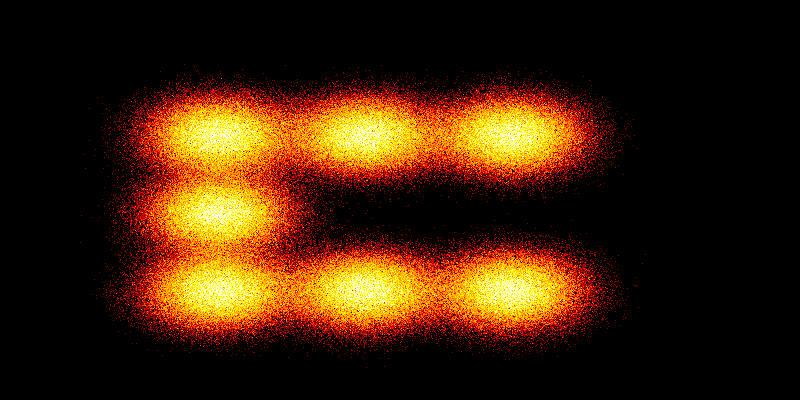

In [41]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot, viridis

img = tf.shade(canvas.points(df,'x','y', agg=reductions.count()), cmap=Hot, how='eq_hist')
tf.set_background(img, 'black')

In [18]:

# TODO: Numba-isze this and take sizes / resolution. 
# TODO: fix x/y transpose issue shown below
a = np.zeros((xsize,ysize),dtype=int)

for i in range(len(data)):
    row = data[i]
#     print(row)
    xi = pos2pix_x(row[0])
    xf = pos2pix_x(row[2])
    yi = pos2pix_y(row[1])
    yf = pos2pix_y(row[3])
#     print(xi,yi,xf,yf)
    x0 = pix2pos_x(xi)
    y0 = pix2pos_y(yi)
    a[xi:xf,yi:yf] += 1


In [19]:
# Let's build an xarray from 'a'
# xarray have a coordinates attribute ('coords'), apart from dimensions ('dims')

xaxis = np.arange(xlims[0], xlims[1], xres)
yaxis = np.arange(ylims[0], ylims[1], yres)
axx = xr.DataArray(a, dims=['x','y'], coords={'x':xaxis, 'y':yaxis})
axx

<xarray.DataArray (x: 2051, y: 2060)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x        (x) int64 -452 -451 -450 -449 -448 -447 -446 -445 -444 -443 ...
  * y        (y) int64 -466 -465 -464 -463 -462 -461 -460 -459 -458 -457 ...

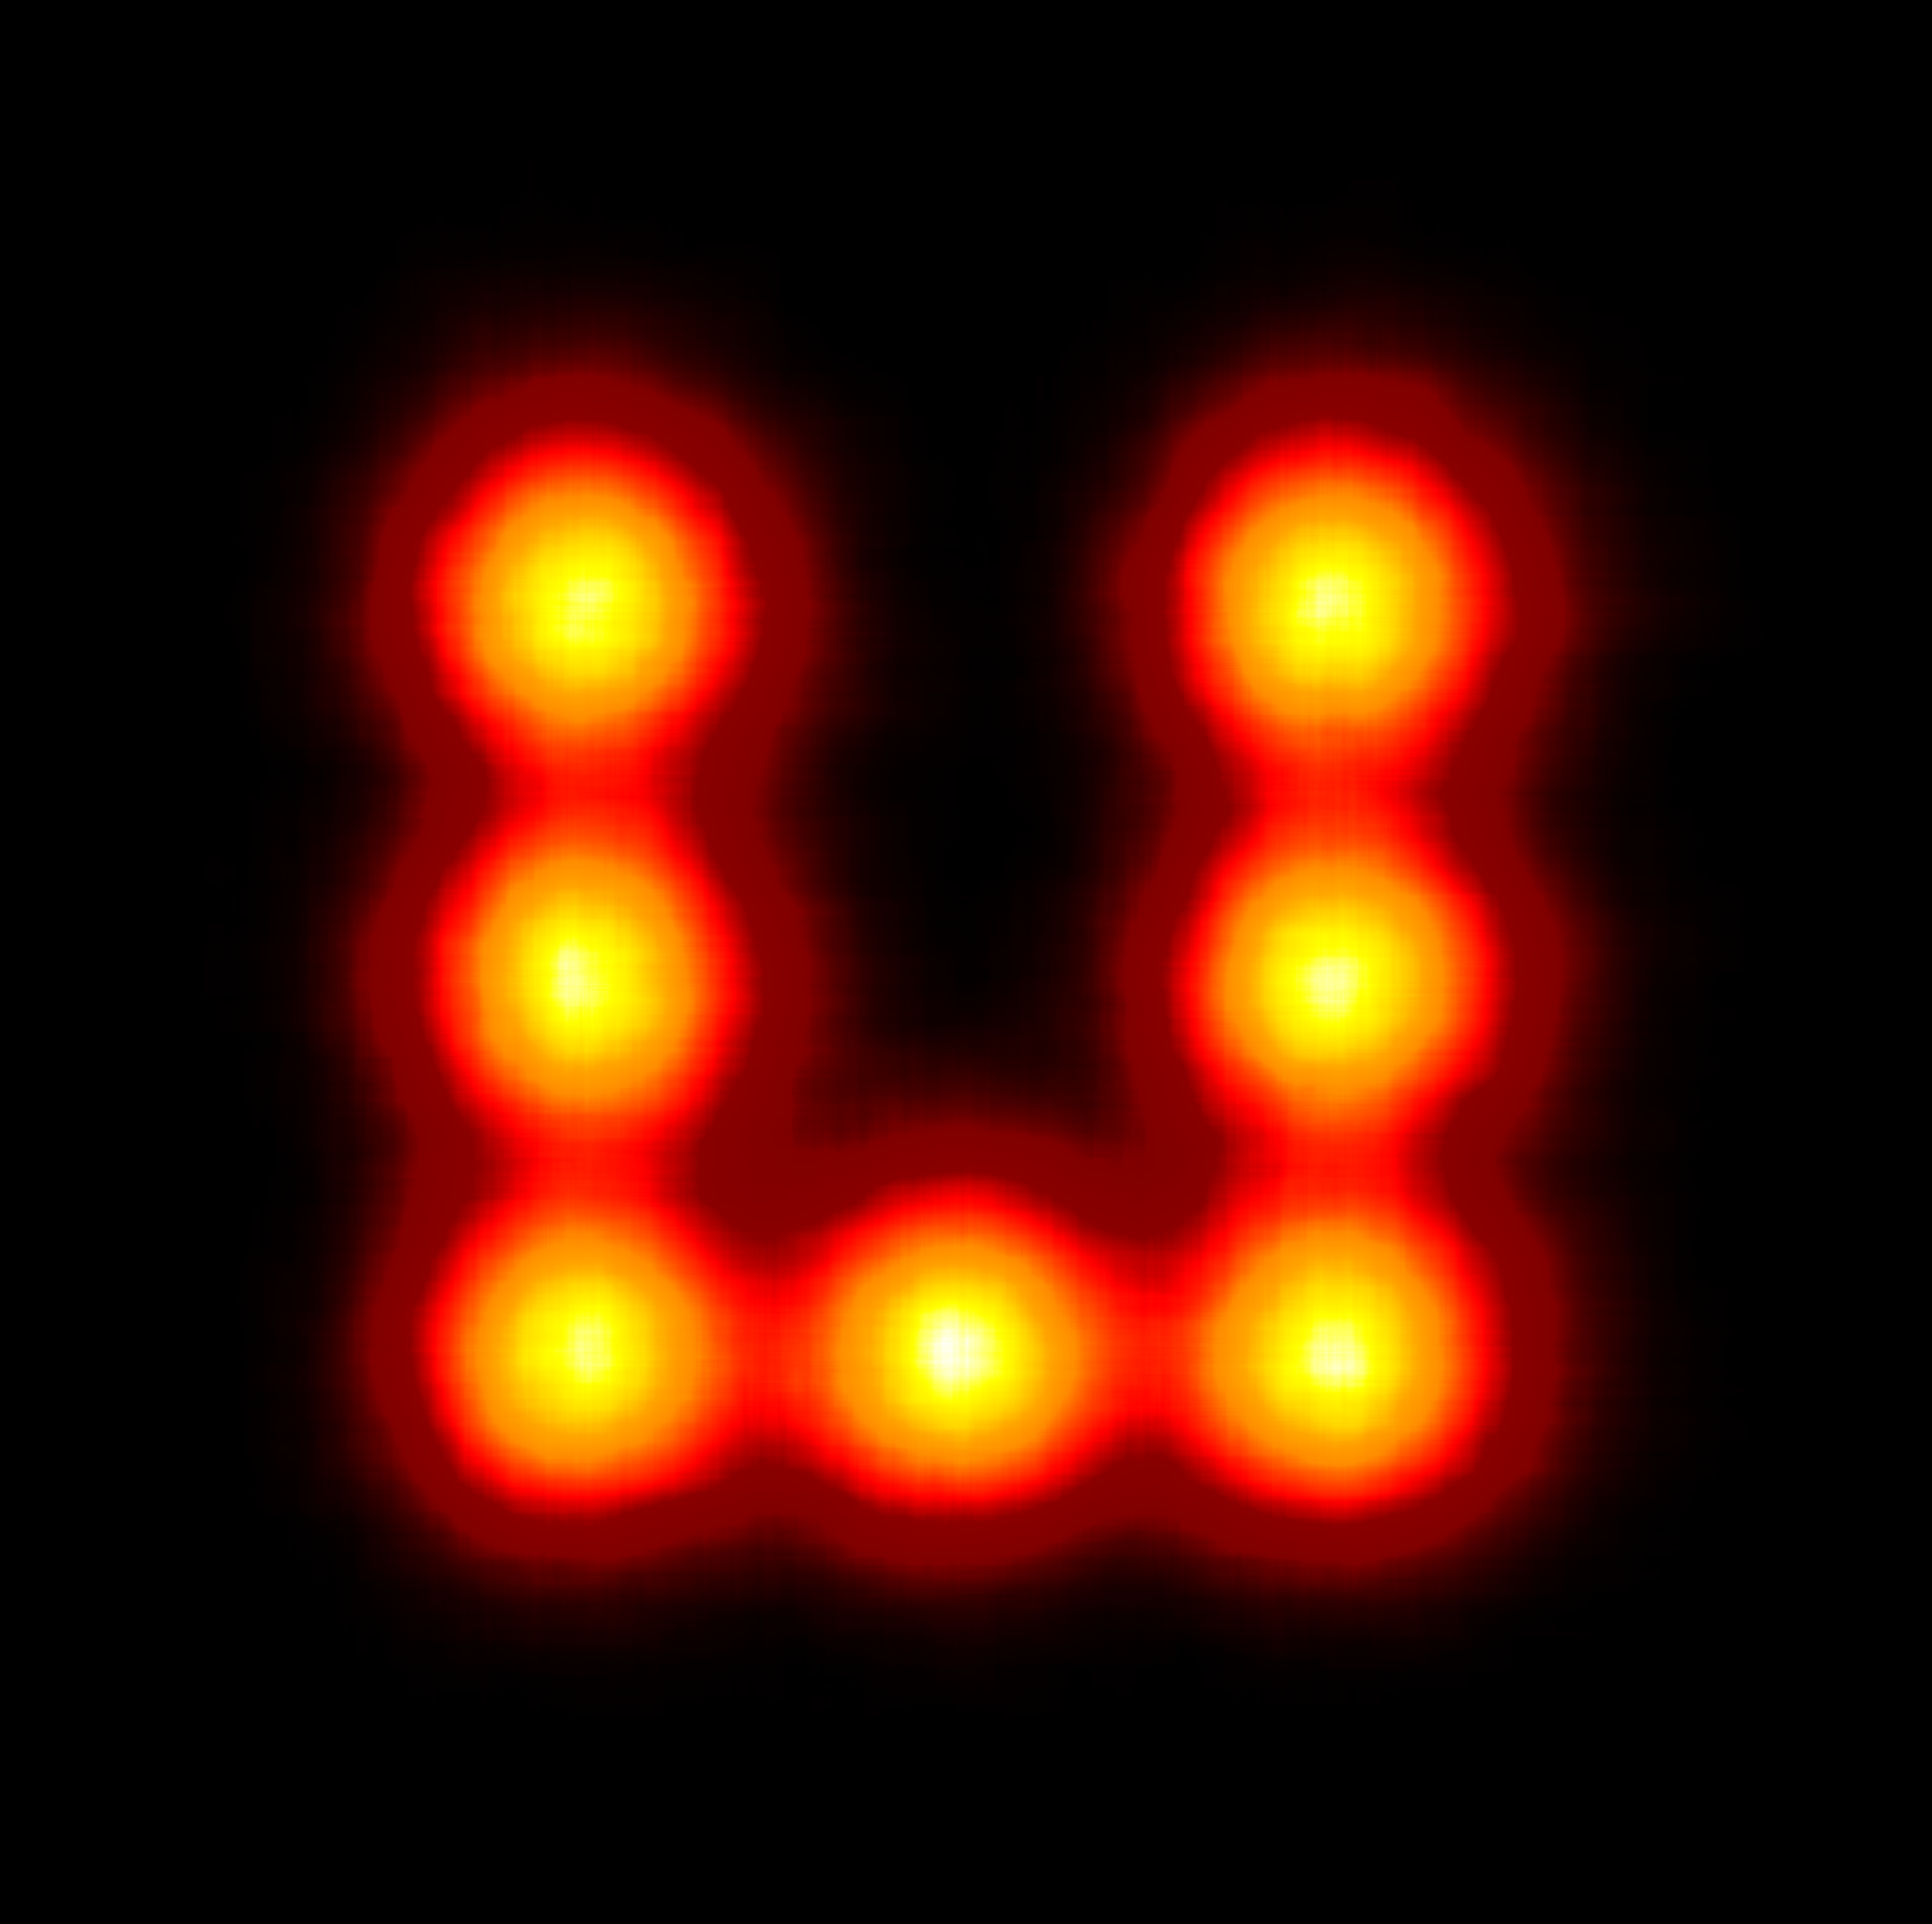

In [43]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot

img = tf.shade(axx, cmap=Hot, how='linear')
tf.set_background(img, 'black')